**Objective**: Build an XGBoost model for predicting heart disease and experiment with hyperparameter tuning to improve its performance.

Dataset: [Heart Disease UCI](https://archive.ics.uci.edu/dataset/45/heart+disease)

# Task 1: Data Loading and Exploration
1. Load the Heart Disease UCI dataset.
2. Explore the dataset to understand its structure and features.
3. Split the data into training and testing sets.

## 1. Load the Heart Disease UCI Dataset

In [97]:
!pip install ucimlrepo

In [98]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

In [99]:
heart_disease = fetch_ucirepo(id=45)

## 2. Explore the dataset to understand its structure and features

In [100]:
X = heart_disease.data.features
y = heart_disease.data.targets

In [101]:
X.shape

(303, 13)

In [102]:
y.shape

(303, 1)

In [103]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


## 3. Split the data into training and testing sets

In [104]:
from sklearn.model_selection import train_test_split

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Task 2: Data Preprocessing
1. Handle missing values if any.
2. Encode categorical variables using appropriate methods.
3. Standardize or normalize numerical features if necessary.

In [106]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 1. Handle missing values if any

In [107]:
X_train.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          3
thal        2
dtype: int64

In [108]:
# Using int64 as well because I loaded the dataset with
# fetch_ucirepo and some numerical features are int64 instead of f64
numerical_features = X.select_dtypes(include= ["float64", "int64"]).columns
numerical_features

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [109]:
imputer = SimpleImputer(strategy="mean")

In [110]:
X_train[numerical_features] = imputer.fit_transform(X_train[numerical_features])

In [111]:
# We dont want to learn the training set, so transform is used instead of fit_transform
X_test[numerical_features] = imputer.transform(X_test[numerical_features])

In [112]:
X_train.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

## 3. Standardize or normalize numerical features if necessary

In [113]:
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

In [114]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(sparse_output=False), categorical_features)
    ]
)

preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')),
                                ('cat', OneHotEncoder(sparse_output=False),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'ca', 'thal'])])

In [115]:
X_train = preprocessor.fit_transform(X_train)

In [116]:
X_train.shape

(242, 38)

In [117]:
X_test = preprocessor.transform(X_test)

# Task 3: Initial XGBoost Model

## 1. Build an initial XGBoost model using default hyperparameters

In [118]:
!pip install xgboost

In [119]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [120]:
xgb_model = XGBClassifier(random_state=42)

## 2 & 3. Train the model on the training set and evaluate its performance on the testing set, note down the accuracy and any other relevant metrics.

In [121]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [122]:
preds = xgb_model.predict(X_test)

acc_suboptimal = accuracy_score(y_test, preds)
acc_suboptimal

0.45901639344262296

# Task 4: Hyperparameter Tuning
1. Experiment with hyperparameter tuning to improve model performance.
2. Adjust hyperparameters such as learning_rate, n_estimators, max_depth, etc.
3. Use techniques like cross-validation to find optimal hyperparameters.
4. Train and evaluate the model with the tuned hyperparameters.

In [123]:
from sklearn.model_selection import GridSearchCV

In [124]:
param_grid = {
    "learning_rate": [0.001, 0.01, 0.1],
    "max_depth": [3, 5, 10],
    "n_estimators": [100, 200, 300]
}

In [125]:
xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring="accuracy")

In [126]:
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [127]:
preds = best_model.predict(X_test)
acc_best = accuracy_score(y_test, preds)
acc_best

0.47540983606557374

# Task 5: Feature Importance
1. Explore feature importance using the **feature_importances_** attribute of the trained XGBoost model.
2. Identify the most important features for heart disease prediction.

In [128]:
import matplotlib.pyplot as plt

In [131]:
importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values()

<Axes: title={'center': 'Feature importances'}>

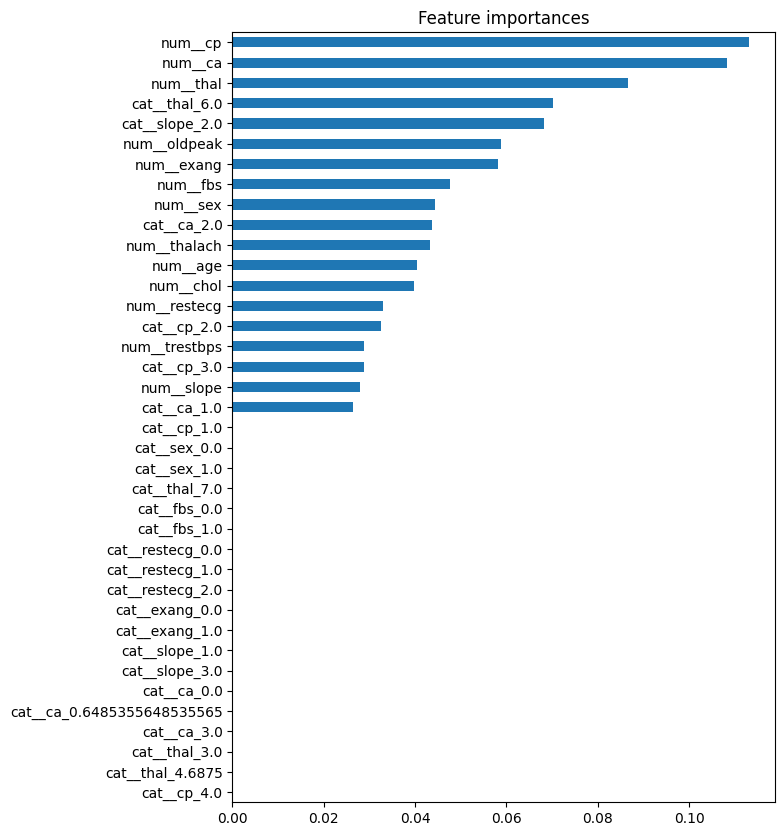

In [168]:
importances.plot.barh(title="Feature importances", figsize=(7, 10))

Those are the most important features when it comes to the prediction of heart disease, in that descending order of importance.

# Task 6: Model Evaluation
1. Compare the performance metrics of the initial model and the tuned model.
2. Visualize the improvement achieved in a clear and concise manner.
3. Discuss the impact of hyperparameter tuning and feature importance on model performance.

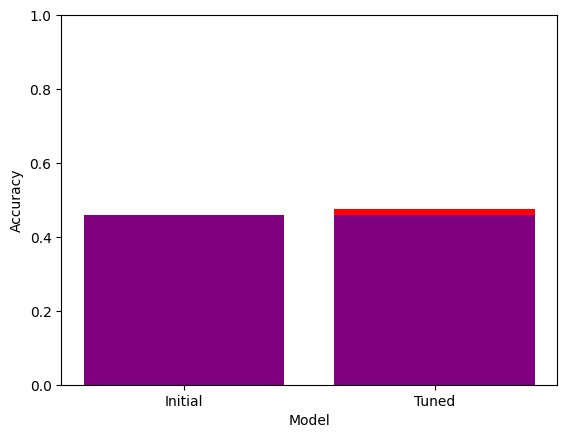

In [167]:
model_names = ["Initial", "Tuned"]
accs = [acc_suboptimal, acc_best]

plt.figure()

plt.bar(model_names, acc_suboptimal, color="purple")
plt.bar(model_names, [0, acc_best - acc_suboptimal], bottom=acc_suboptimal, color="red")

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

plt.show()

Hyperparameter tuning improved overall acuracy, but not in a significative way. More exhausive tuning would be likely to further increase performance, but it would be necessary to change to other methods of tuning, as gridsearch would take too long.